### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?


### Answer:
From the condition in the problem, we can use the formula to know the prediction of the pressue, which is
$$
\begin{aligned}
p_{prediction} = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

We also know the actual pressure, then we can formulate this least square problem, which is

$$
\begin{aligned}
\min_{A12, A21} && \sum_{k=1}^{11}(p_{prediction} - p)^2 \\
\end{aligned}
$$

We use gradient descent method to solve above obejctive function

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython import display

X1 = np.array([[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]])
X2 = np.flip(X1, axis=1).copy()
a = np.array(([[8.07131, 1730.63, 233.426], [7.43155, 1554.679, 240.337]]))
T = 20
p_water = 10 ** (a[0, 0] - a[0, 1] / (T + a[0, 2]))
p_dio = 10 ** (a[1, 0] - a[1, 1] / (T + a[1, 2]))
P = np.array([[28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5]])
P = torch.tensor(P, requires_grad=False, dtype=torch.float32)

A = Variable(torch.tensor([1.0, 1.0]), requires_grad=True)

x1 = torch.tensor(X1, requires_grad=False, dtype=torch.float32)
x2 = torch.tensor(X2, requires_grad=False, dtype=torch.float32)

a = 0.0001

for i in range(100):
    P_pred = x1 * torch.exp(A[0] * (A[1] * x2 / (A[0] * x1 + A[1] * x2)) ** 2) * p_water + \
        x2 * torch.exp(A[1] * (A[0] * x1 / (A[0] * x1 + A[1] * x2)) ** 2) * p_dio

    loss = (P_pred - P) ** 2
    loss = loss.sum()

    loss.backward()

    with torch.no_grad():
        A -= a * A.grad

        A.grad.zero_()

print('Estimation $A_{12}$ and $A_{21}$ is:',A)
print('final loss is:',loss.data.numpy())

Estimation $A_{12}$ and $A_{21}$ is: tensor([1.9110, 1.7293], requires_grad=True)
final loss is: 0.8783658


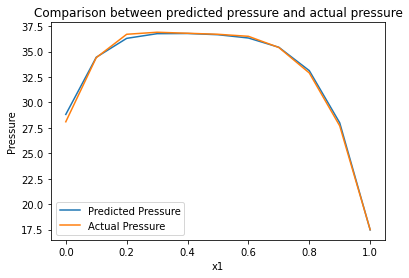

In [7]:
import matplotlib.pyplot as plt
P_pred = P_pred.detach().numpy()[0]
P = P.detach().numpy()[0]
x1 = x1.detach().numpy()[0]

plt.plot(x1, P_pred, label='Predicted Pressure')
plt.plot(x1, P, label='Actual Pressure')
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.legend()
plt.title('Comparison between predicted pressure and actual pressure')
plt.show()

The above curve shows that our model can fit well with the actual data

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).

### Answer:

In [2]:
""" 
Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
            # print()
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

def sample_loss(params):
    """
    objective function definition
    """
    return (4 - 2.1 * params[0] ** 2 + params[0] ** 4 / 3) * params[0] ** 2 + params[0] * params[1] + (-4 + 4 * params[1] ** 2) * params[1] ** 2

bounds = np.array([[-3, 3], [-2, 2]])

xp, yp = bayesian_optimisation(n_iters=30,
                               sample_loss=sample_loss,
                               bounds=bounds,
                               n_pre_samples=20,
                               random_search=100000)

print('minimum objective function:', np.min(yp))
print('x1, x2 when having minumum objective function:',xp[np.argmin(yp)])
print('solution x1, x2:', xp)
print('objective function:', yp)

minimum objective function: -0.9024607886996389
x1, x2 when having minumum objective function: [-0.07180951 -0.6419925 ]
solution x1, x2: [[-1.56429047 -0.21485982]
 [-0.84617403  1.29879546]
 [-1.77198436 -0.38033628]
 [ 1.97343852 -0.34566677]
 [ 0.91186382  0.10925278]
 [-0.05682495  0.15009841]
 [-0.03151155  1.36691775]
 [ 1.28892788  1.44685694]
 [ 0.10159042  0.76587325]
 [ 2.28914538 -1.07420561]
 [-0.30673472  1.23614817]
 [ 1.41937254 -1.44363901]
 [ 1.7829911  -0.20035794]
 [-0.93193908 -0.07470953]
 [ 2.56749444  0.29362611]
 [ 2.61183426 -1.73450176]
 [-0.07180951 -0.6419925 ]
 [-2.95066326 -1.23872875]
 [-2.91082623  1.22466759]
 [ 0.11424894  1.20456218]
 [-2.99993249 -1.52257465]
 [-2.99941621 -1.99912818]
 [-2.85563949 -1.99976097]
 [-2.99937862 -1.94350259]
 [-2.99132561  1.9962955 ]
 [-2.48521156  1.99775382]
 [ 2.99891112  1.99479954]
 [ 2.9989413   1.73402721]
 [ 2.75540121  1.99650252]
 [-2.9993219   0.01863886]
 [-0.7058575  -1.99760692]
 [-2.99816726  1.76225504

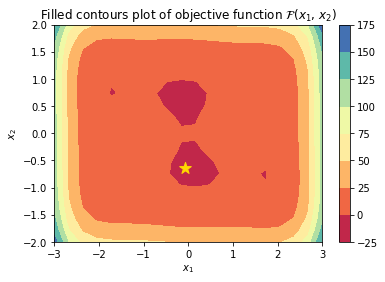

In [5]:
import matplotlib.pyplot as plt
X1 = np.linspace(-3, 3, 20)
X2 = np.linspace(-2, 2, 20)

param_grid = np.array([[x1, x2] for x2 in X2 for x1 in X1])
real_loss = [sample_loss(params) for params in param_grid]

C, G = np.meshgrid(X1, X2)
result = np.array(real_loss).reshape(C.shape)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape), cmap=plt.cm.Spectral)
plt.colorbar(cp)
plt.scatter(xp[np.argmin(yp)][0], xp[np.argmin(yp)][1], marker='*', c='gold', s=150)
plt.title('Filled contours plot of objective function $\mathcal{F}$($x_{1}$, $x_{2}$)')
plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')
plt.show()

The star point reprensents $x_{1}$, $x_{2}$ when minimizing the objective function through Bayesian Optimization.  